In [1]:
from  typing import TypedDict ,List ,Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel,Field
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
class sentiment(BaseModel):
    sentiment : Literal["positive","negative"] =Field(description="Write the sentiment of the given review")

In [3]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm","irritated"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [4]:
model=ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm1=model.with_structured_output(sentiment)
llm2=model.with_structured_output(DiagnosisSchema)

In [5]:
class ReviewState(TypedDict):
    message :str 
    sentiment:Literal["positive","negative"]
    diagnosis:dict
    response:str

In [6]:
def find_sentiment(state:ReviewState):
    prompt=f"Find out the sentiment of the following review {state['message']}"
    sentiment=llm1.invoke(prompt)
    return {'sentiment':sentiment}

def positive_support(state:ReviewState):
    prompt=f"Write a positive response for the following review {state['message']} and also be polite.Also, kindly ask the user to leave feedback on our website."
    response=model.invoke(prompt).content
    return {"response":response}

def should_continue(state:ReviewState)->Literal["positive_support", "run_diagnosis"]:
    """conditional edge for deciding what next we want to do """
    if state['sentiment']=="positive":
        return 'positive_support'
    else :
        return 'run_diagnosis'


def run_diagnosis(state:ReviewState) :
    prompt="""Diagnose the negative response.Find the issue_type , tone , urgency of the user's response"""
    output=llm2.invoke(prompt)
    return {'diagnosis':output.model_dump()}

def negative_support(state:ReviewState):
    diagnosis = state['diagnosis']
    prompt=f"""Write a empathetic,helpful support message regarding the negative response from customer's side keeping in mind the  user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
."""
    output=model.invoke(prompt).content
    return {'response':output}


In [7]:
graph=StateGraph(ReviewState)
graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_support",positive_support)
graph.add_node("negative_support",negative_support)
graph.add_node("run_diagnosis",run_diagnosis)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges(
    "find_sentiment",
    should_continue)
graph.add_edge('positive_support',END)
graph.add_edge('run_diagnosis','negative_support')
graph.add_edge('negative_support',END)

workflow=graph.compile()

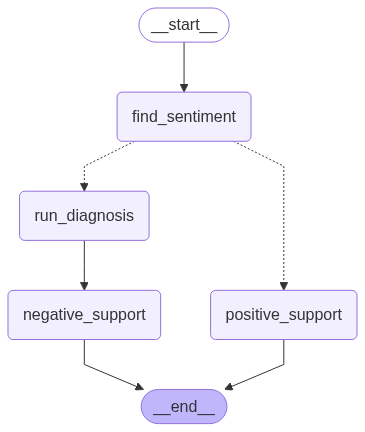

In [8]:
from IPython.display import Image,display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [9]:
prompt={'message':"The phone I bought is horrible it shuts down immediately. I wanna throw it ."}
ans=workflow.invoke(prompt)
print(ans['response'])

Subject: We're Here to Help You Resolve the Issue

Dear [Customer's Name],

Thank you for reaching out and sharing your concerns with us. I truly understand how frustrating it can be to encounter a bug, especially when it impacts your experience and feels urgent. Your feedback is invaluable, and I want to assure you that we are here to support you every step of the way.

I apologize for any inconvenience this issue has caused you. Our team is committed to resolving it as quickly as possible. To help us address this matter effectively, could you please provide any additional details about the bug you’re experiencing? This information will assist us in diagnosing the problem and finding a solution more swiftly.

We appreciate your patience and understanding as we work to resolve this. Your satisfaction is our top priority, and we are dedicated to ensuring you have a seamless experience moving forward.

Thank you for your understanding, and I look forward to hearing from you soon.

Warm r